In [1]:
import Dataloader
import Model
import torch
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt

import torch.optim as optim
from torch import nn

from time import time

import cv2

In [2]:
device = torch.device('cuda:0')

In [3]:
sentence_len = 11
dataset = Dataloader.flickr8000_subset(sentence_len=sentence_len)

In [4]:
print(len(dataset))

4468


In [5]:
vocabulary_size = len(dataset.dictionary)
show_and_tell = Model.LSTM(vocabulary_size = vocabulary_size,hidden_size=1024).to(device)

Initialized embedding matrices for p(y | a, y_prev)
Initialized memory state and hidden state fc layers for LSTM
Initialized soft version of attention mechanism
Beta Initialized
Initialized LSTM


In [6]:
vgg = Model.VGG()

In [7]:
vgg.vgg19 = vgg.vgg19.to(device)

In [8]:
batch_size = 32
dataloader = DataLoader(dataset,batch_size=batch_size)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(show_and_tell.parameters(),lr=0.0001)

In [10]:
words = list(dataset.dictionary.keys())

In [11]:
start_index_key = list(dataset.dictionary.keys()).index("<START>")

In [500]:
num_epochs = 75
lmbda = 1.

for epoch in range(num_epochs):
    t_start = time()
    attention_LOSS = 0
    word_LOSS = 0
        
    for images,captions,labels in dataloader:

        a = vgg(images.squeeze().to(device))
        hn,cn = show_and_tell.init_hidden(a)

        
        alphas = torch.zeros(a.shape[0],sentence_len,a.shape[2]).to(device)

        y_prev = torch.zeros((a.shape[0],1,vocabulary_size)).to(device)
        y_prev[:,:,start_index_key] = 1
        
        sentence_prediction = []

        for t in range(dataset.sentence_len):
            yt = captions.squeeze()[:,t,:].unsqueeze(dim=1).to(device)
            y_pred,hn,cn,alpha_i = show_and_tell.forward(a,y_prev,hn,cn)

            """with torch.no_grad():
                print(words[y_pred[0].argmax(1).item()])
            """
            y_prev = yt
            
            sentence_prediction.append(y_pred.squeeze(1).unsqueeze(2))
            
            alphas[:,t,:] = alpha_i.squeeze(1)
            
            
        attention_loss = lmbda * ((1. - alphas.sum(dim=1))**2).sum(1).mean()
        word_loss = criterion(torch.cat(sentence_prediction,dim=2),labels.squeeze(1).to(device))
        loss = attention_loss + word_loss

        attention_LOSS += (attention_loss.detach().item()*a.shape[0])
        word_LOSS += (word_loss.detach().item()*a.shape[0])
        
        optimizer.zero_grad()

        loss.backward()
        
        optimizer.step()
        
    epoch_time = time()-t_start
    print("Epoch {}: Pred Loss={} Attn Loss={}    {}:{}".format(epoch,(word_LOSS)/len(dataset),(attention_LOSS)/len(dataset),int(epoch_time//60),int(epoch_time%60)))

Epoch 0: Pred Loss=0.3844764895383652 Attn Loss=174.64910671469775    0:44
Epoch 1: Pred Loss=0.3611553313215609 Attn Loss=174.64752727293393    0:44
Epoch 2: Pred Loss=0.3592592534361509 Attn Loss=174.64771741356503    0:43
Epoch 3: Pred Loss=0.3577329042561906 Attn Loss=174.64785625898315    0:47
Epoch 4: Pred Loss=0.3619875258756943 Attn Loss=174.64823798825938    0:48
Epoch 5: Pred Loss=0.3782543341229831 Attn Loss=174.6499762880877    0:49
Epoch 6: Pred Loss=0.37341598527390935 Attn Loss=174.65030629867513    0:49
Epoch 7: Pred Loss=0.3658284712232643 Attn Loss=174.64967231443126    0:49
Epoch 8: Pred Loss=0.3631784687270623 Attn Loss=174.64995959494513    0:48
Epoch 9: Pred Loss=0.35471986315564163 Attn Loss=174.64847553085832    0:46
Epoch 10: Pred Loss=0.3416210739283873 Attn Loss=174.64758952387552    0:49
Epoch 11: Pred Loss=0.32723490401582195 Attn Loss=174.64688011995895    0:46
Epoch 12: Pred Loss=0.3121841957820988 Attn Loss=174.6455573591678    0:47
Epoch 13: Pred Loss=0

KeyboardInterrupt: 

In [329]:
torch.save(show_and_tell.state_dict(),r'C:\Users\lpott\Desktop\Coursera\Projects\Show_and_Tell\weights.pth')

In [330]:
show_and_tell.load_state_dict(torch.load('weights.pth'))

<All keys matched successfully>

## Show example...

In [331]:
IMAGE_PATH = r'C:\Users\lpott\Desktop\Coursera\Projects\Show_and_Tell\dataset\images'

In [716]:
index=114

In [717]:
input,caption,labels = dataset[index]

In [718]:
"""
for index in range(4000):
    print(index)
    img1 = dataset.dataset[index,0]
    plt.imshow(cv2.resize(plt.imread(os.path.join(IMAGE_PATH,img1)),(224,224)))
    plt.show()
"""

'\nfor index in range(4000):\n    print(index)\n    img1 = dataset.dataset[index,0]\n    plt.imshow(cv2.resize(plt.imread(os.path.join(IMAGE_PATH,img1)),(224,224)))\n    plt.show()\n'

In [719]:
img1 = dataset.dataset[index,0]

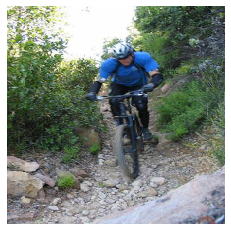

In [724]:
plt.imshow(cv2.resize(plt.imread(os.path.join(IMAGE_PATH,img1)),(224,224)))
plt.axis('off')
plt.show()

predicted word: A


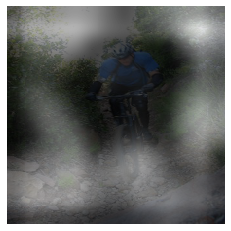

predicted word: mountain


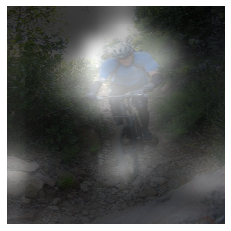

predicted word: biker


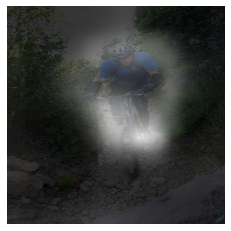

predicted word: in


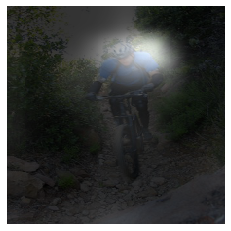

predicted word: blue


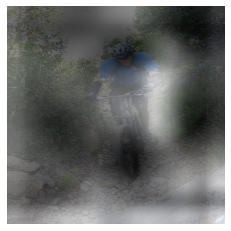

predicted word: rides


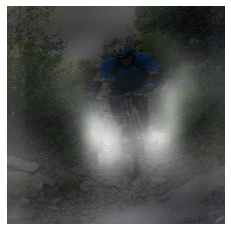

predicted word: through


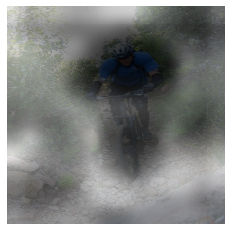

predicted word: a


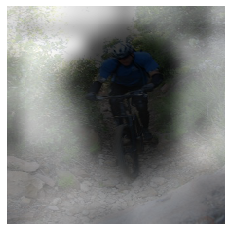

predicted word: wooded


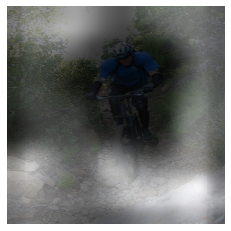

predicted word: area


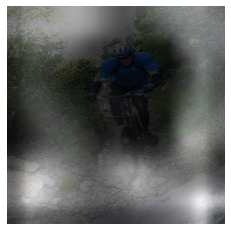

predicted word: .


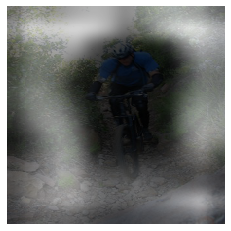

In [726]:
with torch.no_grad():
    a = vgg(input.to(device))
    hn,cn = show_and_tell.init_hidden(a)
    y_prev = torch.zeros((a.shape[0],1,vocabulary_size)).to(device)
    y_prev[:,:,start_index_key] = 1

    for t in range(dataset.sentence_len):
        yt = caption[:,t,:].unsqueeze(dim=1).to(device)
        y_pred,hn,cn,alpha_i= show_and_tell.forward(a,y_prev,hn.to(device),cn.to(device))
        #print("true:",words[yt.argmax().item()])
        print("predicted word:",words[y_pred[0].argmax(1).item()])
        
        y_prev = torch.zeros((a.shape[0],1,vocabulary_size)).to(device)
        y_prev[:,:,y_pred.argmax()] = 1
        
        resized_attention = cv2.resize(alpha_i.view(14,14).cpu().detach().numpy(),(224,224),fx=16,fy=16)
        blur_attention = cv2.GaussianBlur(resized_attention,(7,7),0)
        
        plt.imshow(cv2.resize(plt.imread(os.path.join(IMAGE_PATH,img1)),(224,224)))
        plt.imshow(blur_attention,cmap='gray',alpha=.8)
        plt.axis('off')
        plt.show()